# Example code of Segment Anything Model (SAM)

Colab 환경에서 SAM 모델을 사용해 이미지에 클릭한 위치의 객체를 segmentation 하는 예제입니다.

In [12]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/MrSyee/SAM-remove-background/blob/main/jupyternotebook/sam_click.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Colab 환경 설정
예제를 실행시키기 위해 python package들을 설치합니다. 예제로 사용할 이미지들도 다운로드 받습니다.

In [ ]:
# Local에서 Run하는 경우 False로 변경
using_colab = True

In [ ]:
if using_colab:
    !wget https://raw.githubusercontent.com/mrsyee/sam-remove-background/main/jupyternotebook/requirements.txt
    !pip install -r requirements.txt

    # Download examples
    !mkdir examples
    !cd examples && wget https://raw.githubusercontent.com/mrsyee/sam-remove-background/main/assets/examples/mannequin.jpeg

## Import dependency

In [1]:
import os
import urllib
from typing import Tuple

import cv2
import gradio as gr
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

## Set constant

In [2]:
CHECKPOINT_PATH = os.path.join("checkpoint")
CHECKPOINT_NAME = "sam_vit_h_4b8939.pth"
CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
MODEL_TYPE = "default"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Initialize and load pre-trained SAM

In [3]:
if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH, exist_ok=True)
checkpoint = os.path.join(CHECKPOINT_PATH, CHECKPOINT_NAME)
if not os.path.exists(checkpoint):
    urllib.request.urlretrieve(CHECKPOINT_URL, checkpoint)
sam = sam_model_registry[MODEL_TYPE](checkpoint=checkpoint).to(DEVICE)

In [4]:
predictor = SamPredictor(sam)

## Inference model

### 예제 이미지 불러오기

In [5]:
image = cv2.imread("examples/mannequin.jpeg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

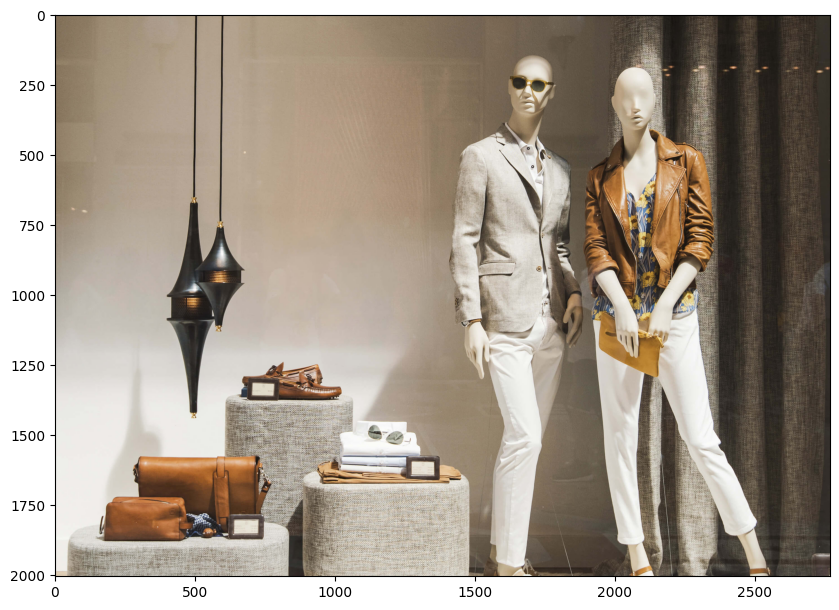

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("on")
plt.show()

### Point 입력하기
원하는 위치의 객체를 segmentation 하기 위해서는 원하는 위치를 Point로 입력해야합니다. SAM 모델에 Point를 입력하기 위해서는 두 가지 정보가 필요합니다.

- point_coords: Point 좌표 (x, y)
- points_labels: Point의 타입. Point 위치의 객체를 선택하려면 Positive Click(1)로 설정.

In [7]:
point_coords = np.array([[1720, 230]])
points_labels = np.array([1])

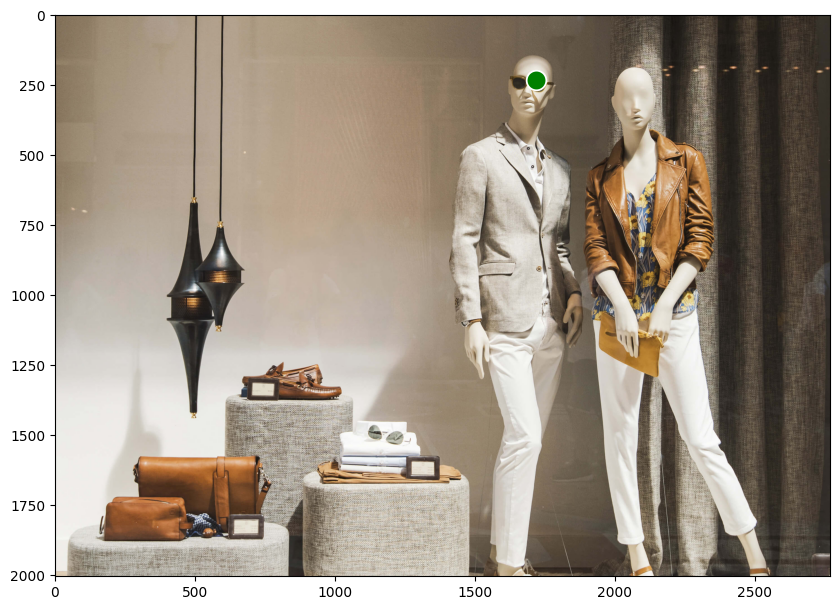

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.gca().scatter(
    point_coords[0, 0],
    point_coords[0, 1],
    color="green",
    marker="o",
    s=200,
    edgecolor="white",
    linewidth=1.25,
)
plt.axis("on")
plt.show()

### SAM 모델 추론
predictor의 predict 함수를 통해 추론합니다. 추론의 결과로 2 가지 정보가 출력됩니다.

- masks: 입력한 정보에 대해 3개의 mask가 출력.
- scores: 3개의 mask의 퀄리티에 대한 모델의 평가 점수. 점수가 가장 높을수록 퀄리티가 높은 mask입니다.
- low_res_logits: 저해상도 mask 출력. 이 예제에서는 사용하지 않습니다.

In [9]:
predictor.set_image(image)
masks, scores, _ = predictor.predict(point_coords, points_labels)

Mask 0


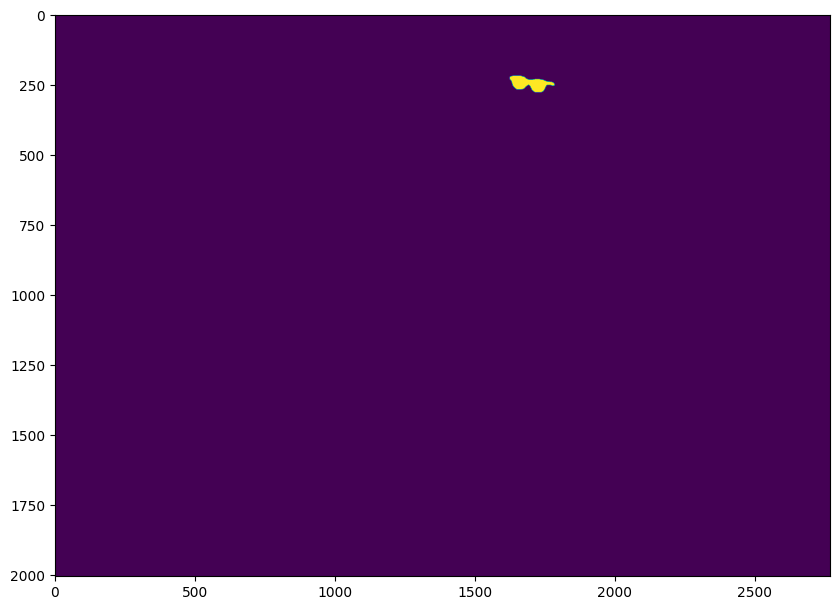

Mask 1


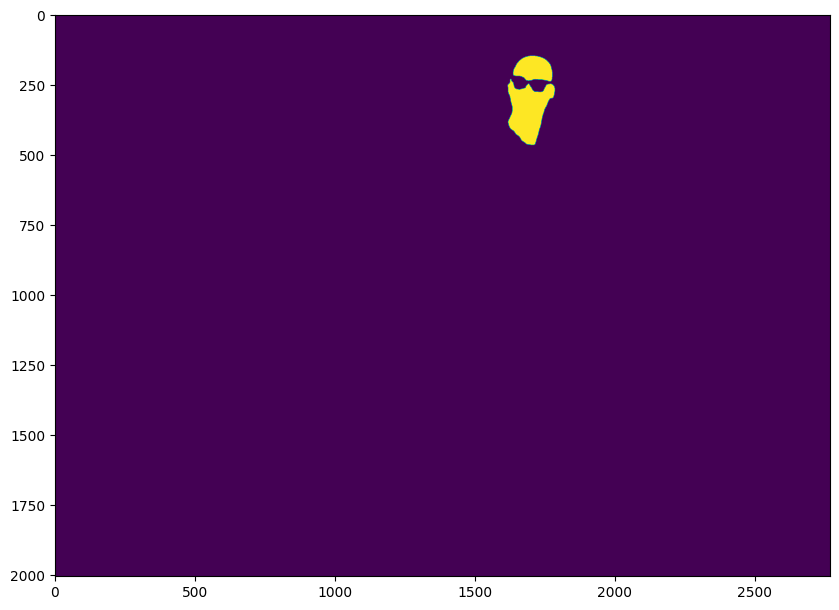

Mask 2


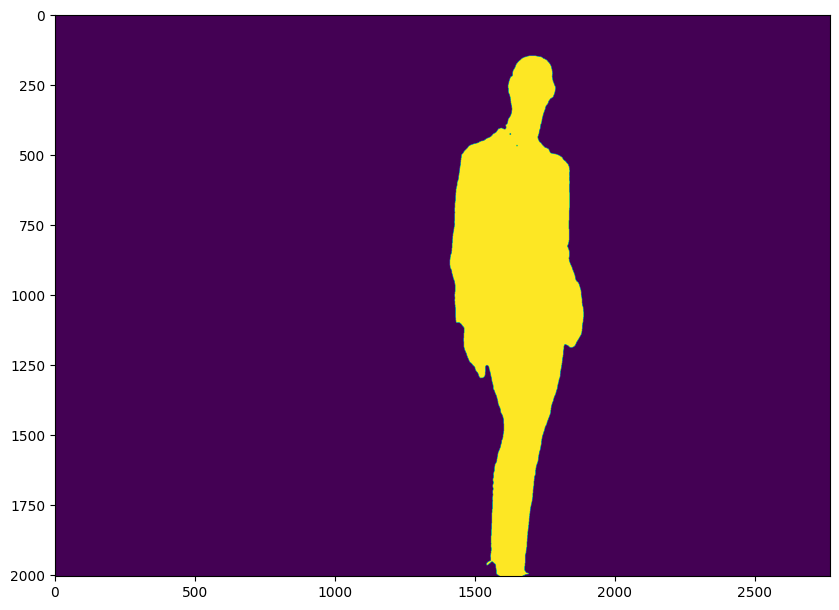

In [10]:
for i, mask in enumerate(masks):
    print(f"Mask {i}")
    plt.figure(figsize=(10, 10))
    plt.imshow(mask)
    plt.axis("on")
    plt.show()

## Segment with one click

In [12]:
def select_masks(
    masks: np.ndarray, iou_preds: np.ndarray, num_points: int
) -> Tuple [np.ndarray, np.ndarray]:
    # Determine if we should return the multiclick mask or not from the number of points.
    # The reweighting is used to avoid control flow.
    # Reference: https://github.com/facebookresearch/segment-anything/blob/6fdee8f2727f4506cfbbe553e23b895e27956588/segment_anything/utils/onnx.py#L92-L105
    score_reweight = np.array([1000] + [0] * 2)
    score = iou_preds + (num_points - 2.5) * score_reweight
    best_idx = np.argmax(score)
    masks = np.expand_dims(masks[best_idx, :, :], axis=-1)
    iou_preds = np.expand_dims(iou_preds[best_idx], axis=0)
    return masks, iou_preds


def segment(image: np.ndarray, point_x: int, point_y: int) -> np.ndarray:
    points_coords = np.array([[point_x, point_y], [0, 0]])
    points_label = np.array([1, -1])

    # Inference SAM Decoder model with point information.
    masks, scores, _ = predictor.predict(points_coords, points_label)

    # Select the best mask based on the score.
    mask, _ = select_masks(masks, scores, points_coords.shape[0])
    mask = (mask > 0).astype(np.uint8) * 255
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    return mask

## UI: Upload image and click

In [18]:
def set_image(image: np.ndarray):
    # Preprocess image and get image embedding with SAM Encoder
    predictor.set_image(image)

def get_coords(evt: gr.SelectData):
    return evt.index[0], evt.index[1]

def segment_by_click(image: np.ndarray, evt: gr.SelectData):
    click_w, click_h = evt.index
    return segment(image, click_w, click_h)

with gr.Blocks() as app:
    gr.Markdown("# Example of SAM with 1 click")
    with gr.Row():
        coord_w = gr.Number(label="Mouse coords w")
        coord_h = gr.Number(label="Mouse coords h")

    with gr.Row():
        input_img = gr.Image(label="Input image").style(height=600)
        output_img = gr.Image(label="Output image").style(height=600)
    
    input_img.upload(set_image, [input_img], None)
    input_img.select(get_coords, None, [coord_w, coord_h])
    input_img.select(segment_by_click, [input_img], output_img)

In [ ]:
app.launch(inline=False, share=True)

In [17]:
app.close()

Closing server running on port: 7861
